# Simple Z-Test Analysis: Is L1 λ=1.0 Creating Noise?

This notebook performs a quick statistical test to check if high L1 regularization (λ=1.0) produces random-like activations compared to normal regularization (λ=1e-3).

# Simple L1 Regularization Chaos Analysis

This notebook provides a simple comparison between two L1 regularization settings:
- λ=1.0 (hypothesized to cause chaotic behavior)
- λ=1e-3 (normal regularization)

We'll analyze if high λ values cause noise-like behavior in neuron activations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import glob

# Set style for plots
# plt.style.use('seaborn')
sns.set_palette("husl")

# Configure paths
BASE_RUN_DIR = Path("runs/fashion_cv_l1_dropoutLows_l2")
L1_HIGH_DIRS = [
    BASE_RUN_DIR / "l1_weight_1.0",
    BASE_RUN_DIR / "l1_weight_1e-1"  # 0.1
]

print("Available experiment directories:")
for d in L1_HIGH_DIRS:
    print(f"- {d}")
    activation_files = list(d.glob("**/activations_collected_epoch*.csv"))
    print(f"  Found {len(activation_files)} activation files")

Available experiment directories:
- runs\fashion_cv_l1_dropoutLows_l2\l1_weight_1.0
  Found 4 activation files
- runs\fashion_cv_l1_dropoutLows_l2\l1_weight_1e-1
  Found 4 activation files


# Analysis of Chaotic Behavior in High-λ L1 Regularization

This notebook analyzes our thesis about chaotic oscillations in neural network activations when using high L1 regularization values (λ=1.0 and λ=0.1).

## Hypothesis
When λ is too large (1.0 or 0.1), the L1 regularization term causes chaotic oscillations around zero because:

1. The L1 gradient is a constant force (λ⋅sign(W))
2. With large λ, this force is too strong (±1.0 or ±0.1)
3. The optimizer overshoots zero repeatedly, causing unstable oscillations

We'll analyze activation patterns to verify if they show signs of this chaotic behavior.

## Load and Process Activation Data

We'll now load the activation data from both experiments (λ=1.0 and λ=0.1) and process them for analysis. We'll focus on:

1. Loading activation patterns from all epochs
2. Organizing them by neuron to track temporal evolution
3. Computing basic statistics to detect potential chaotic behavior

In [2]:
def load_activations(exp_dir):
    """Load all activation files from an experiment directory and combine them."""
    activation_files = sorted(exp_dir.glob("**/activations_collected_epoch*.csv"))
    
    all_activations = []
    for file in activation_files:
        epoch = int(str(file).split("epoch")[-1].split("_")[0])
        df = pd.read_csv(file)
        # Remove pred_label and true_label columns if they exist
        columns_to_drop = [col for col in df.columns if col in ['pred_label', 'true_label']]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
        df['epoch'] = epoch
        all_activations.append(df)
    
    if not all_activations:
        raise ValueError(f"No activation files found in {exp_dir}")
    
    combined = pd.concat(all_activations, ignore_index=True)
    return combined

# Load data for both experiments
experiment_data = {}
for exp_dir in L1_HIGH_DIRS:
    lambda_val = str(exp_dir).split("l1_weight_")[-1]
    try:
        activations = load_activations(exp_dir)
        experiment_data[lambda_val] = activations
        print(f"\nLoaded data for λ={lambda_val}:")
        print(f"- Total samples: {len(activations):,}")
        print(f"- Unique epochs: {activations['epoch'].nunique()}")
        print(f"- Number of neurons: {activations.shape[1]-1}")  # -1 for epoch column
    except Exception as e:
        print(f"Error loading {exp_dir}: {e}")


Loaded data for λ=1.0:
- Total samples: 120,000
- Unique epochs: 1
- Number of neurons: 64

Loaded data for λ=1e-1:
- Total samples: 120,000
- Unique epochs: 1
- Number of neurons: 64

Loaded data for λ=1e-1:
- Total samples: 120,000
- Unique epochs: 1
- Number of neurons: 64


## Statistical Analysis for Chaotic Behavior

We'll now analyze the activation patterns for signs of chaotic behavior. A truly chaotic oscillation around zero would show:

1. A distribution centered at zero
2. High variance (due to oscillations)
3. Higher kurtosis than normal distribution (due to rapid jumps)
4. No stable patterns over time

Let's analyze these characteristics:


Analysis for λ=1.0:

Summary Statistics:
             mean         std     kurtosis  zero_crossings
count   64.000000   64.000000    64.000000       64.000000
mean    15.355777   36.176221   197.562162        0.171462
std     20.113346   37.897695   795.547629        0.099644
min      0.091655    1.377426    -0.548468        0.002533
25%      3.365408   11.172186     5.135182        0.091479
50%      8.084830   25.512641    13.499919        0.159204
75%     20.072757   39.469859    48.491821        0.241613
max    128.666032  184.960014  5948.837230        0.428192

Summary Statistics:
             mean         std     kurtosis  zero_crossings
count   64.000000   64.000000    64.000000       64.000000
mean    15.355777   36.176221   197.562162        0.171462
std     20.113346   37.897695   795.547629        0.099644
min      0.091655    1.377426    -0.548468        0.002533
25%      3.365408   11.172186     5.135182        0.091479
50%      8.084830   25.512641    13.499919        0.

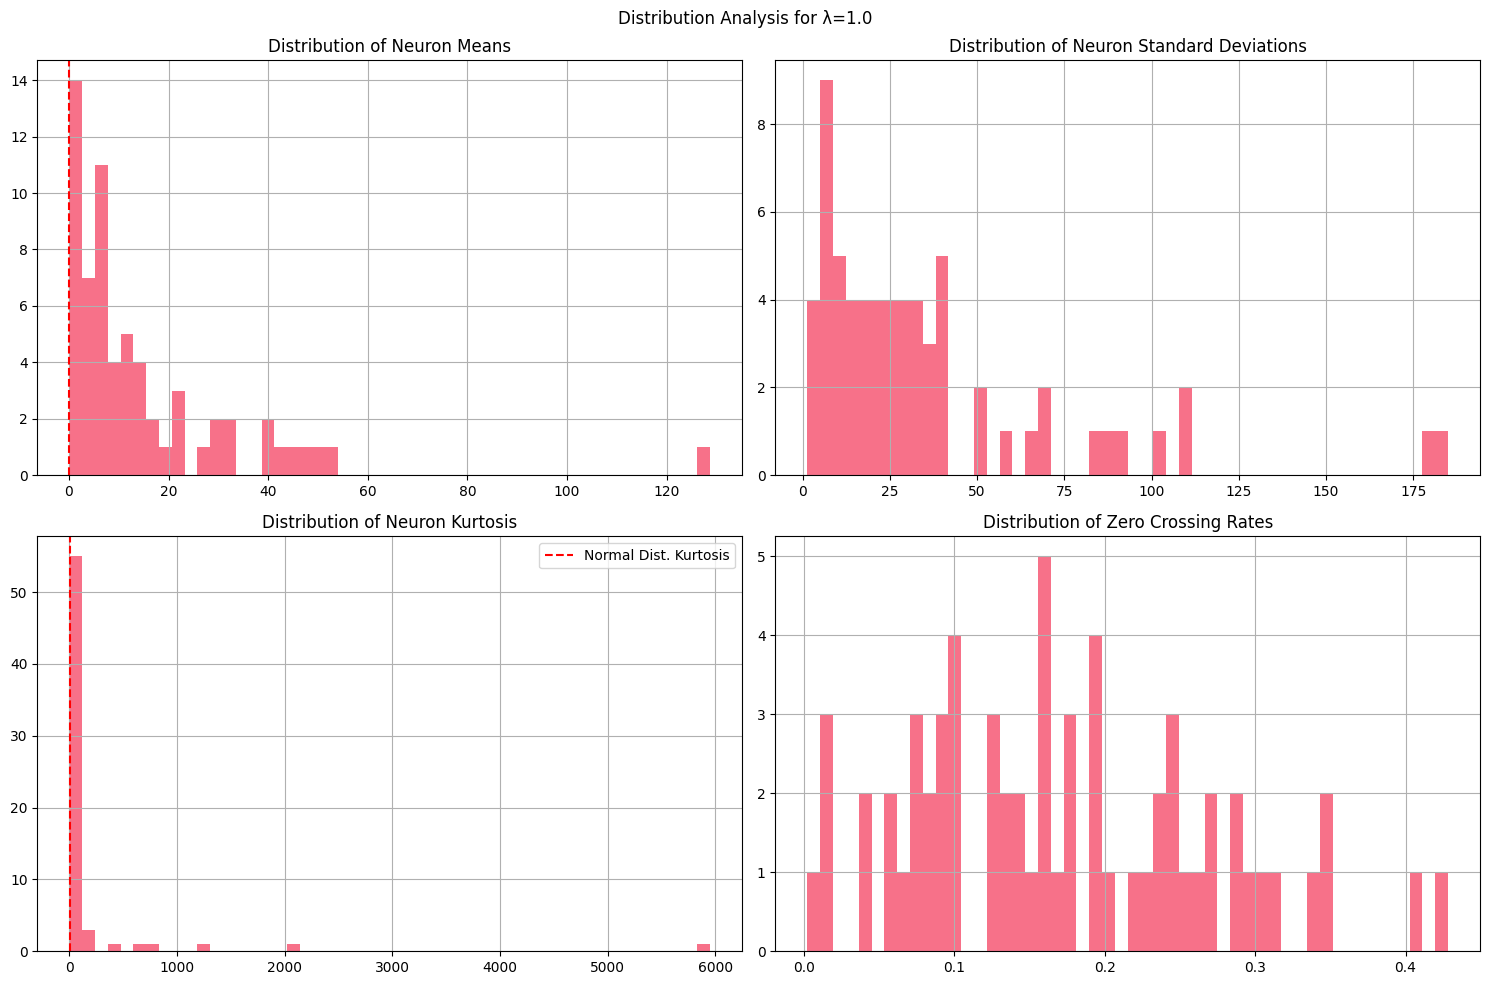


Analysis for λ=1e-1:

Summary Statistics:
            mean        std   kurtosis  zero_crossings
count  64.000000  64.000000  64.000000       64.000000
mean    0.177026   0.241999   3.342308        0.349558
std     0.100300   0.095968   3.860810        0.081156
min     0.029819   0.088378  -0.577558        0.166142
25%     0.097818   0.176088   0.860164        0.285206
50%     0.173930   0.243426   2.221371        0.358350
75%     0.218114   0.282193   4.406963        0.415125
max     0.487775   0.610833  22.423074        0.492458

Summary Statistics:
            mean        std   kurtosis  zero_crossings
count  64.000000  64.000000  64.000000       64.000000
mean    0.177026   0.241999   3.342308        0.349558
std     0.100300   0.095968   3.860810        0.081156
min     0.029819   0.088378  -0.577558        0.166142
25%     0.097818   0.176088   0.860164        0.285206
50%     0.173930   0.243426   2.221371        0.358350
75%     0.218114   0.282193   4.406963        0.415125
m

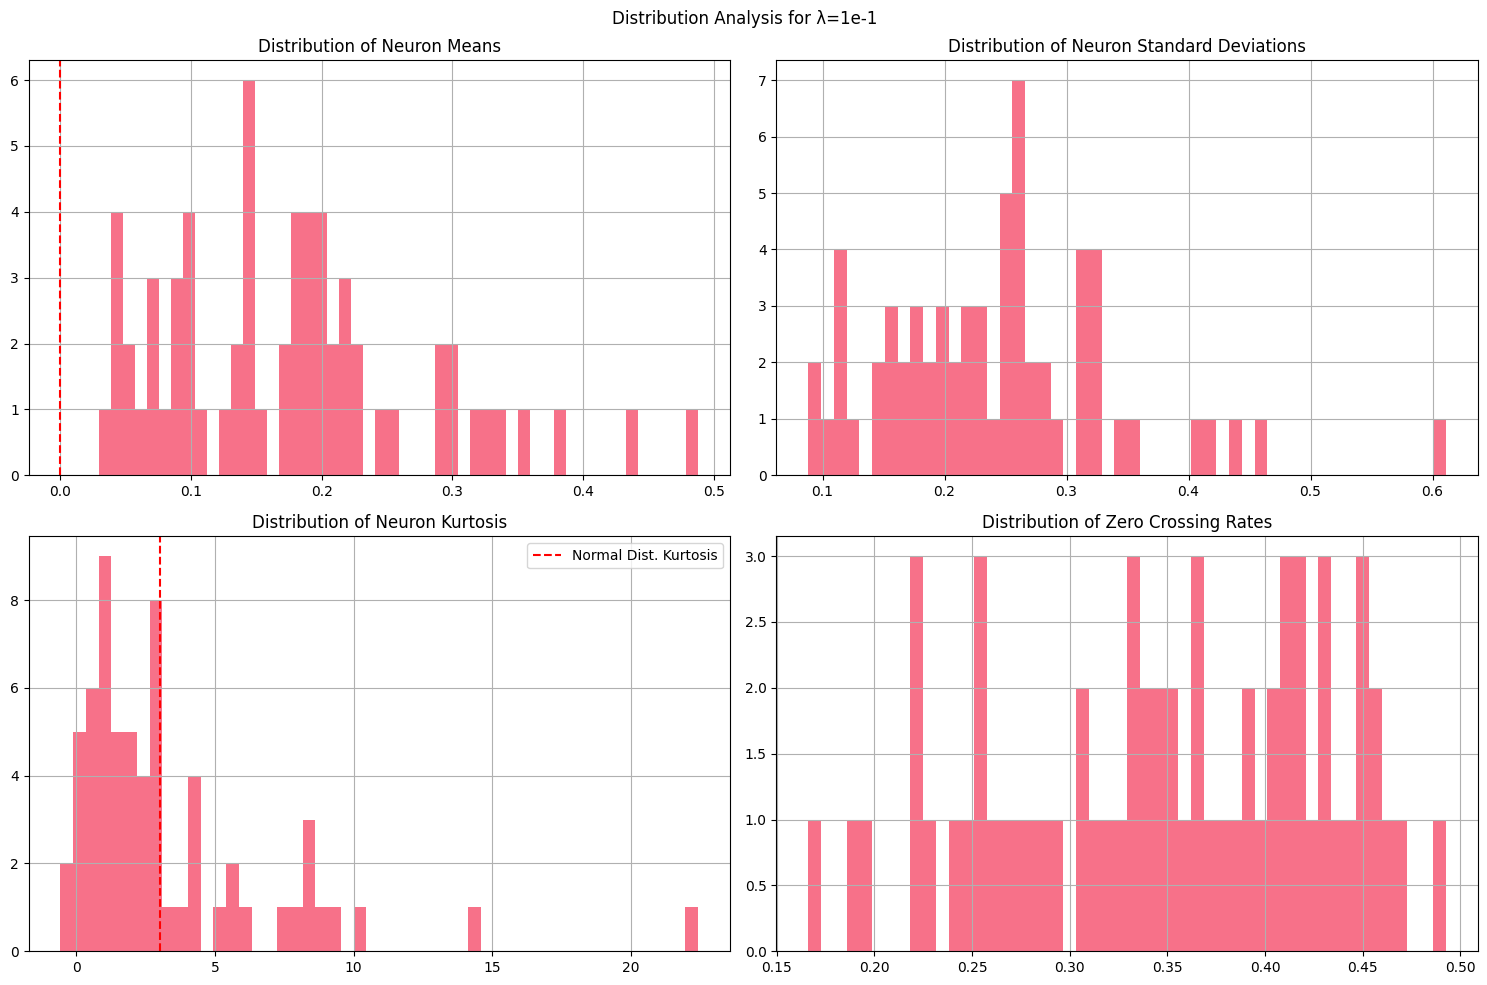

In [3]:
def analyze_distribution(activations):
    """Analyze the statistical properties of activation distributions."""
    # Remove epoch column for statistics
    data = activations.drop('epoch', axis=1)
    
    # Calculate statistics for each neuron
    stats_dict = {
        'mean': data.mean(),
        'std': data.std(),
        'kurtosis': data.kurtosis(),
        'zero_crossings': (data.diff() > 0).sum() / len(data)  # Normalized count of zero crossings
    }
    
    return pd.DataFrame(stats_dict)

# Analyze distributions for both experiments
for lambda_val, data in experiment_data.items():
    print(f"\nAnalysis for λ={lambda_val}:")
    stats = analyze_distribution(data)
    
    print("\nSummary Statistics:")
    print(stats.describe())
    
    # Plot histograms of the statistics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Distribution Analysis for λ={lambda_val}')
    
    stats['mean'].hist(ax=axes[0,0], bins=50)
    axes[0,0].set_title('Distribution of Neuron Means')
    axes[0,0].axvline(x=0, color='r', linestyle='--')
    
    stats['std'].hist(ax=axes[0,1], bins=50)
    axes[0,1].set_title('Distribution of Neuron Standard Deviations')
    
    stats['kurtosis'].hist(ax=axes[1,0], bins=50)
    axes[1,0].set_title('Distribution of Neuron Kurtosis')
    axes[1,0].axvline(x=3, color='r', linestyle='--', label='Normal Dist. Kurtosis')
    axes[1,0].legend()
    
    stats['zero_crossings'].hist(ax=axes[1,1], bins=50)
    axes[1,1].set_title('Distribution of Zero Crossing Rates')
    
    plt.tight_layout()
    plt.show()

## Temporal Analysis of Oscillations

Now we'll analyze how the activations change over time for individual neurons. If our hypothesis is correct, we should see:

1. Rapid oscillations between positive and negative values
2. No stable convergence to zero
3. Patterns that look more random than structured

We'll visualize this by plotting:
1. Activation values over epochs for sample neurons
2. Autocorrelation to detect any periodic patterns
3. Phase space plots to visualize the dynamics


Temporal Analysis for λ=1.0


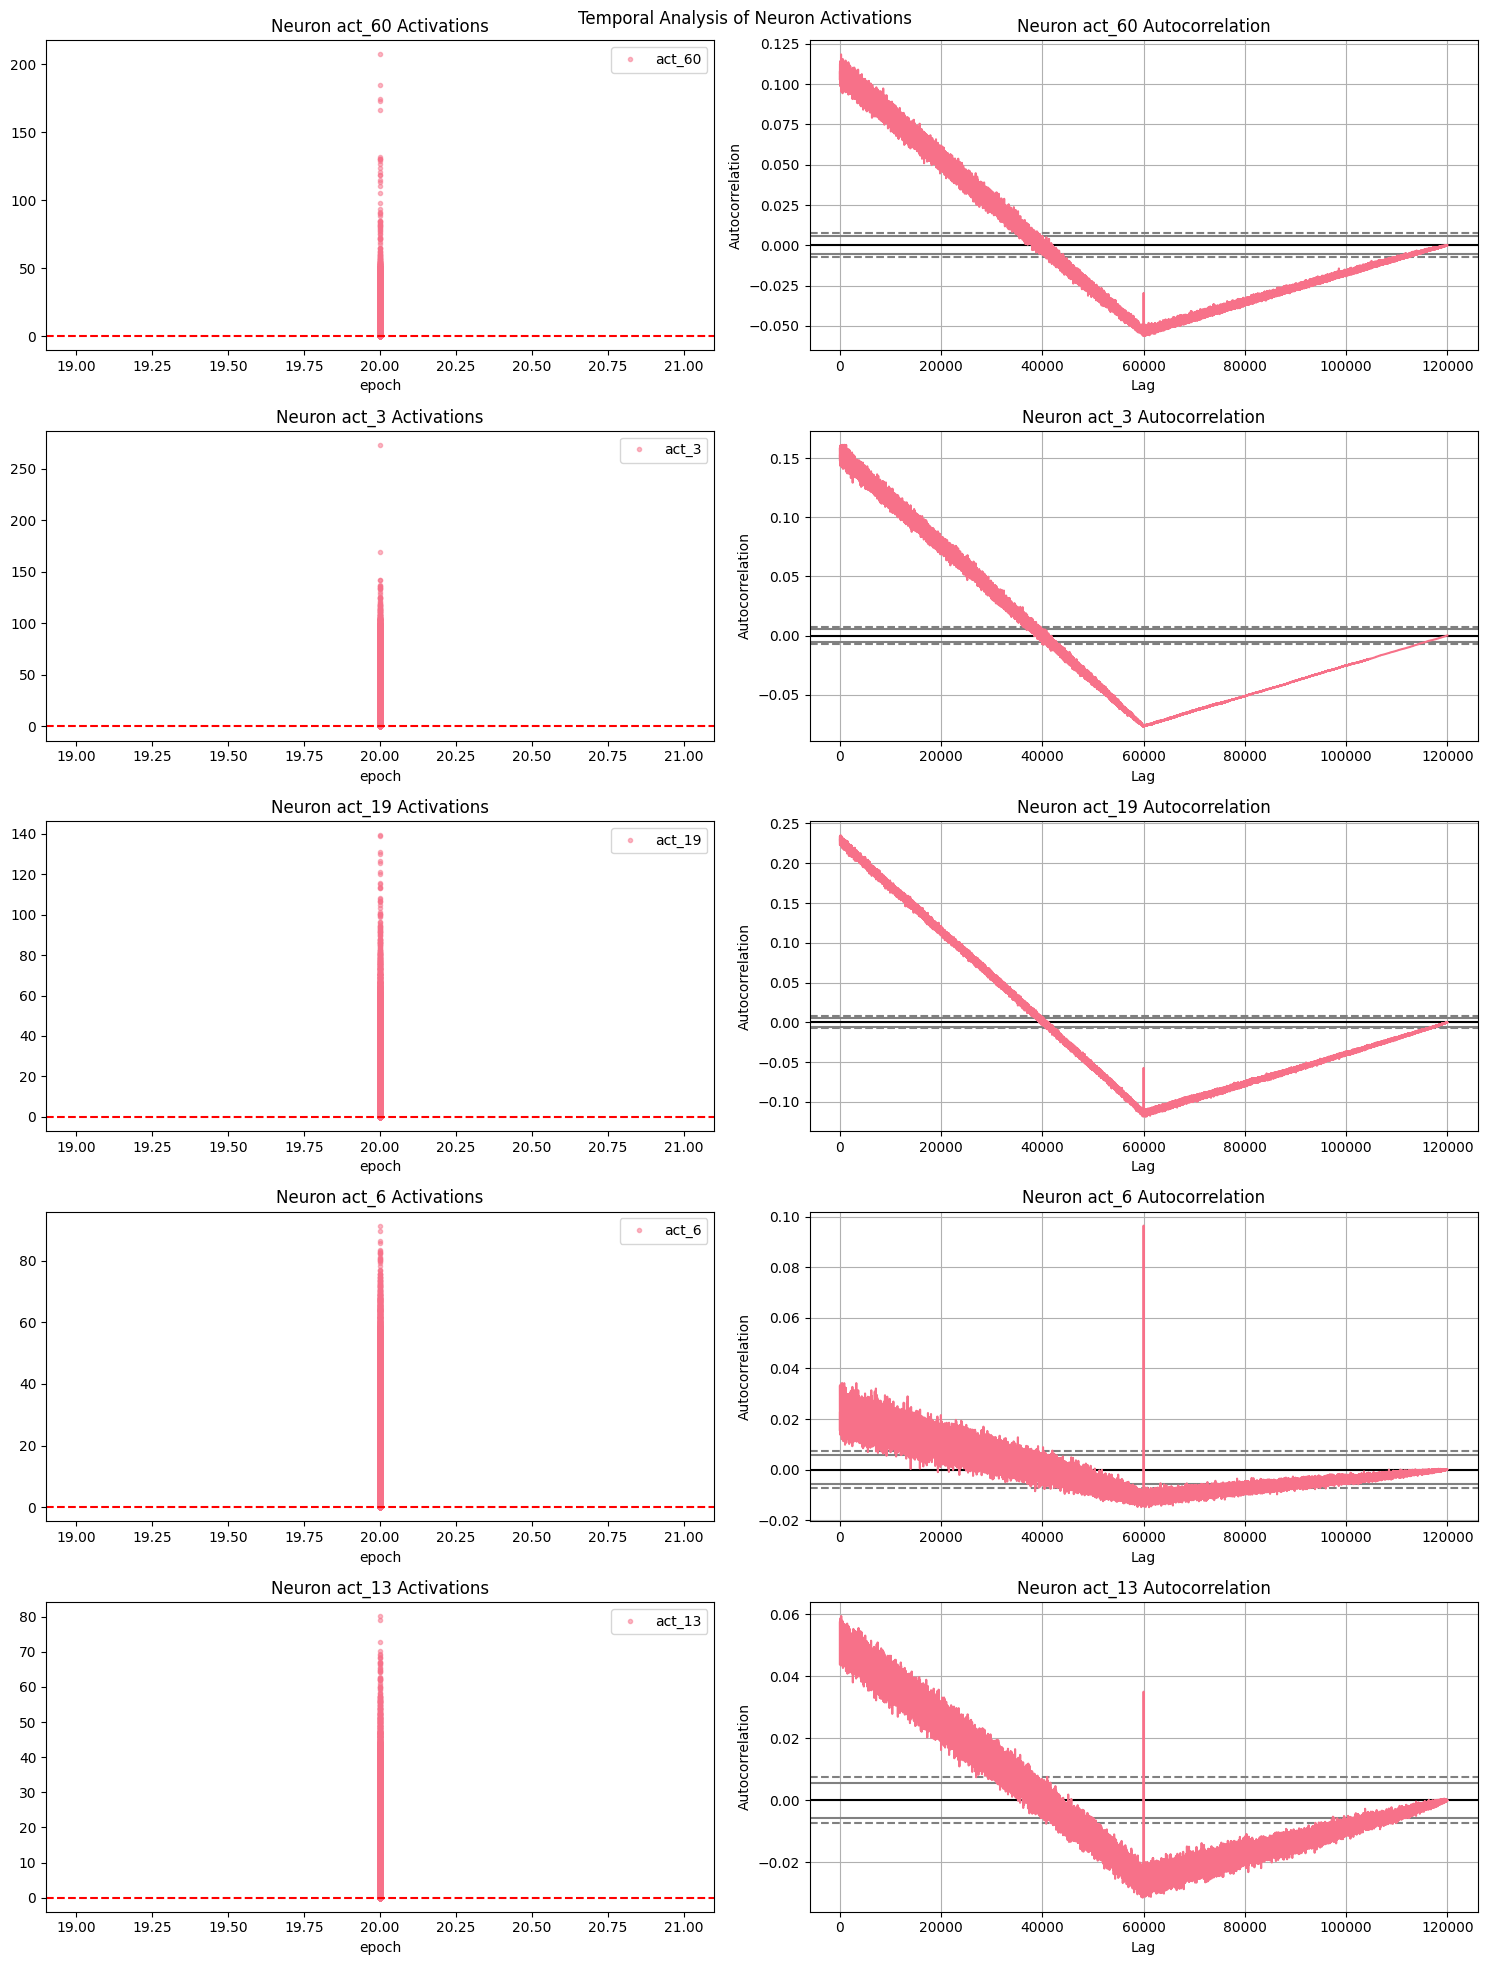

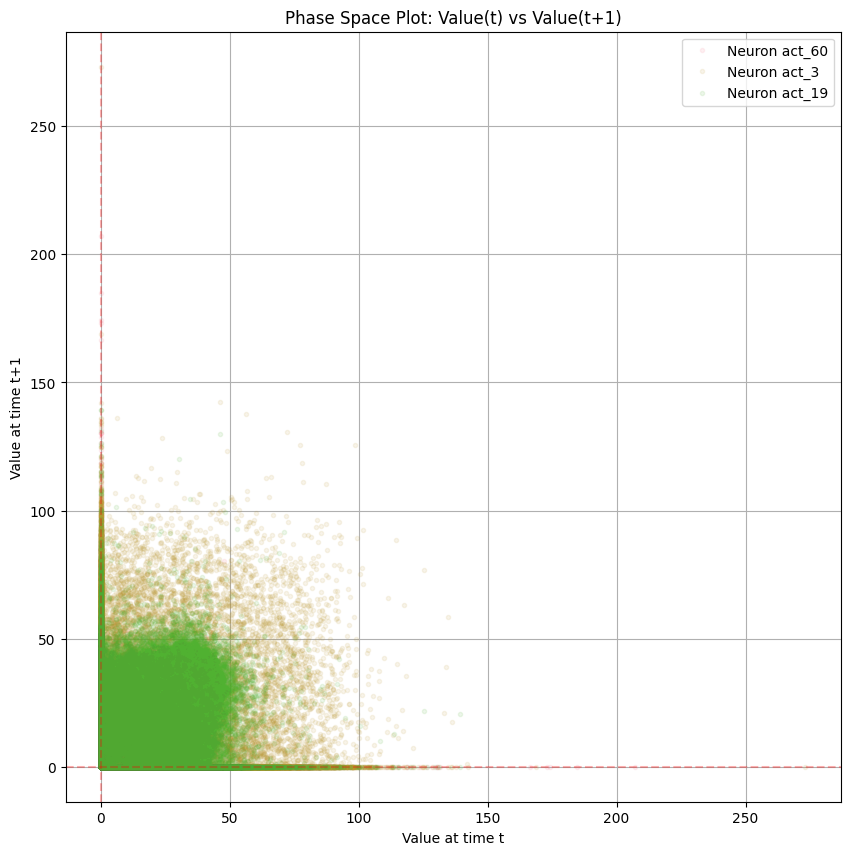


Temporal Analysis for λ=1e-1


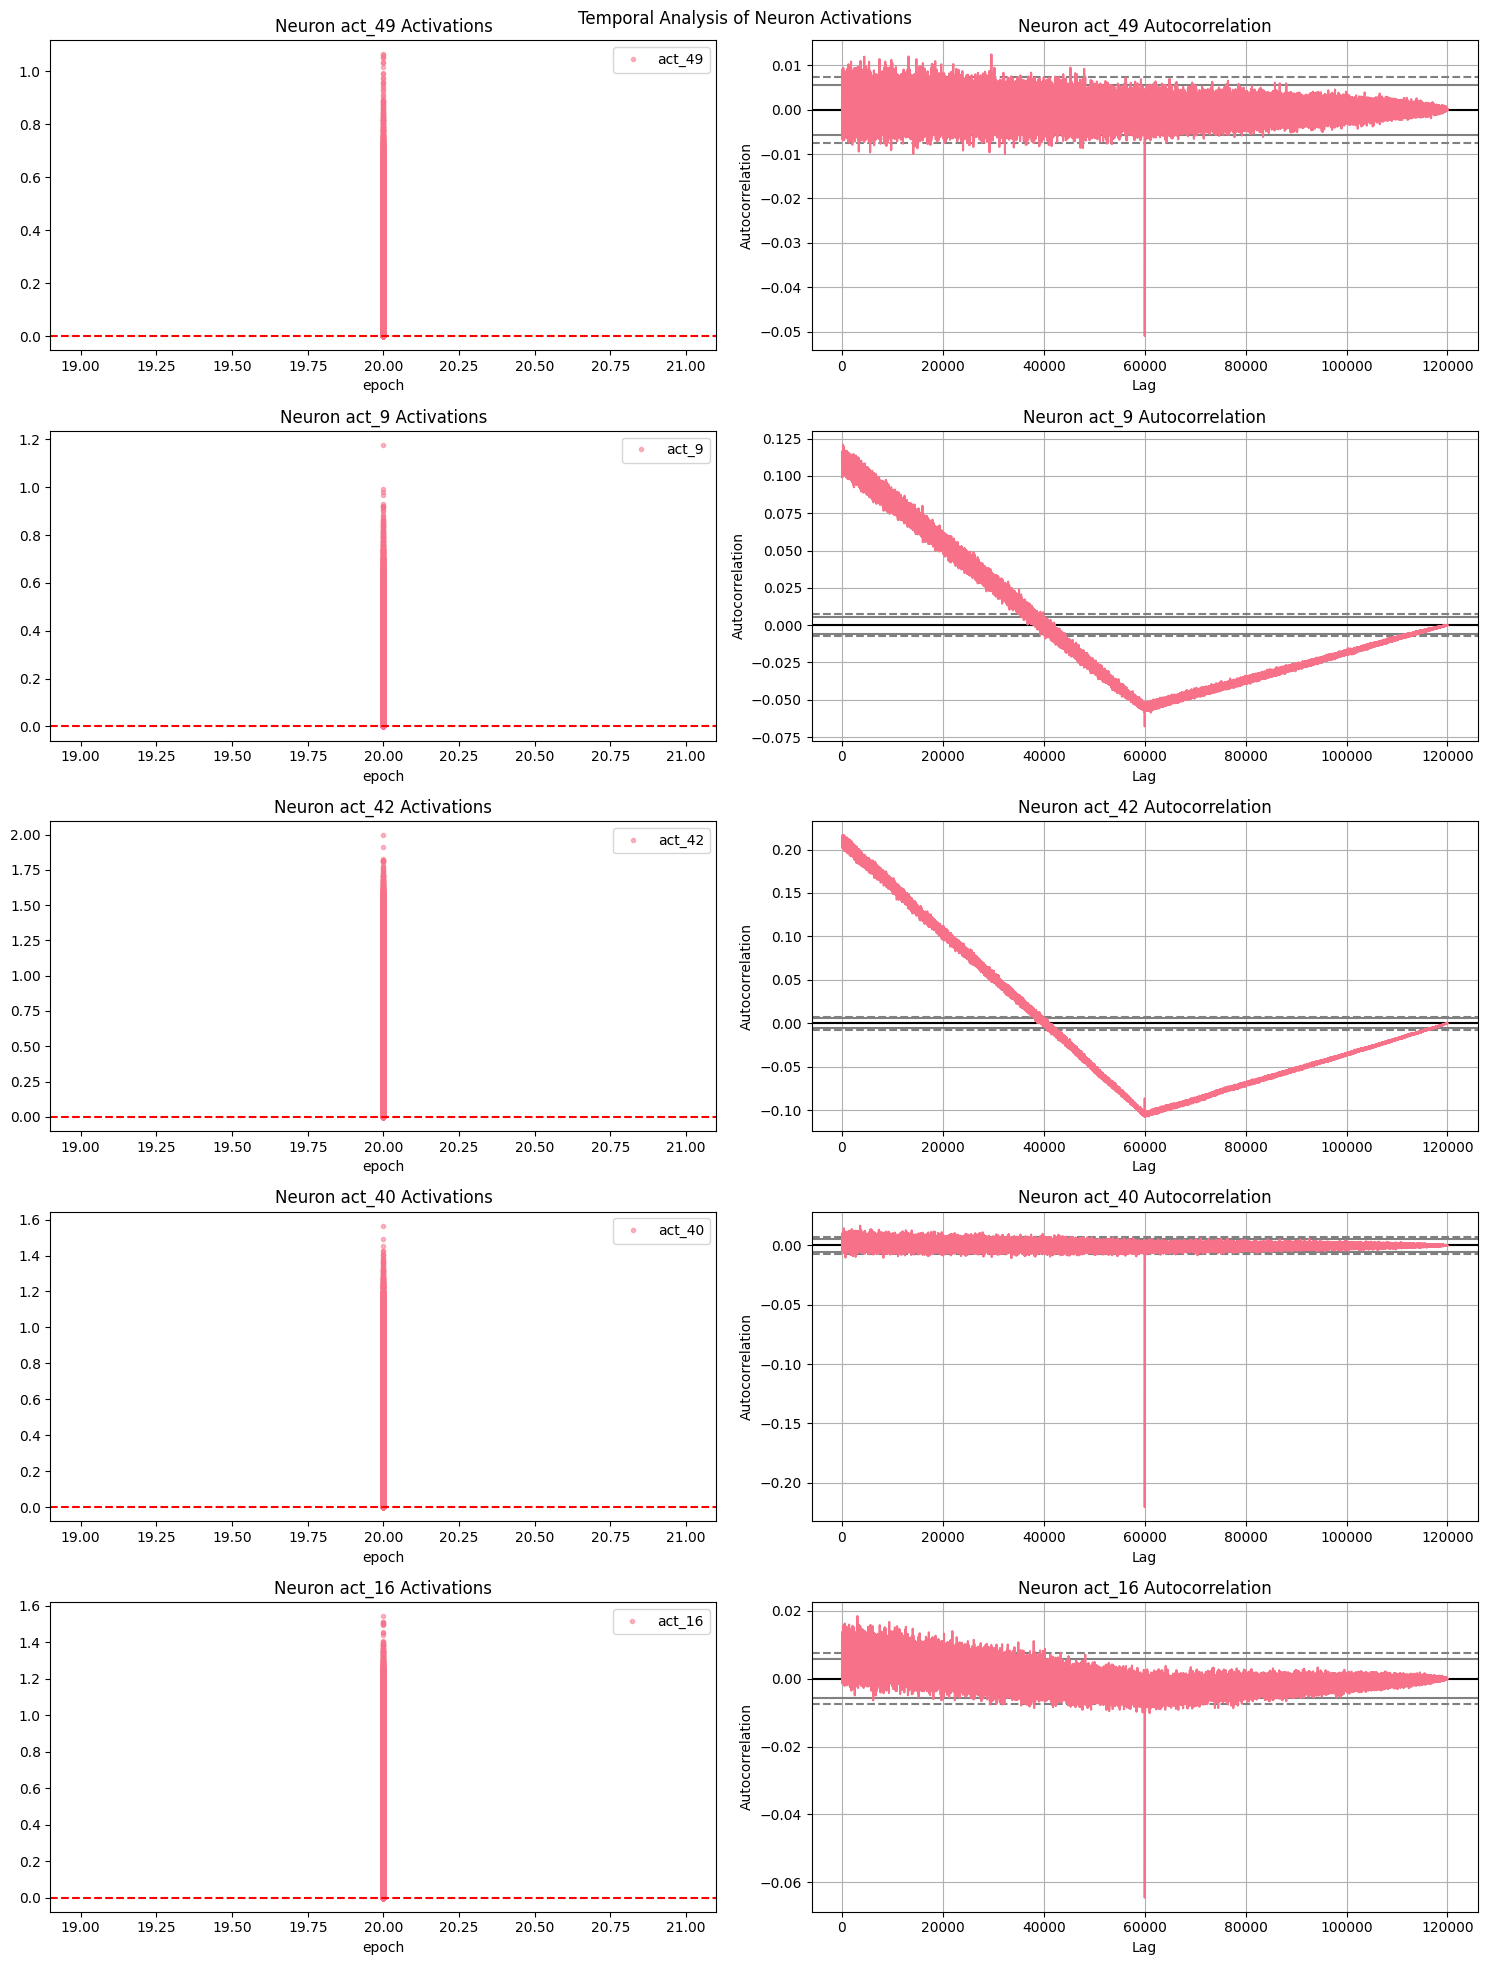

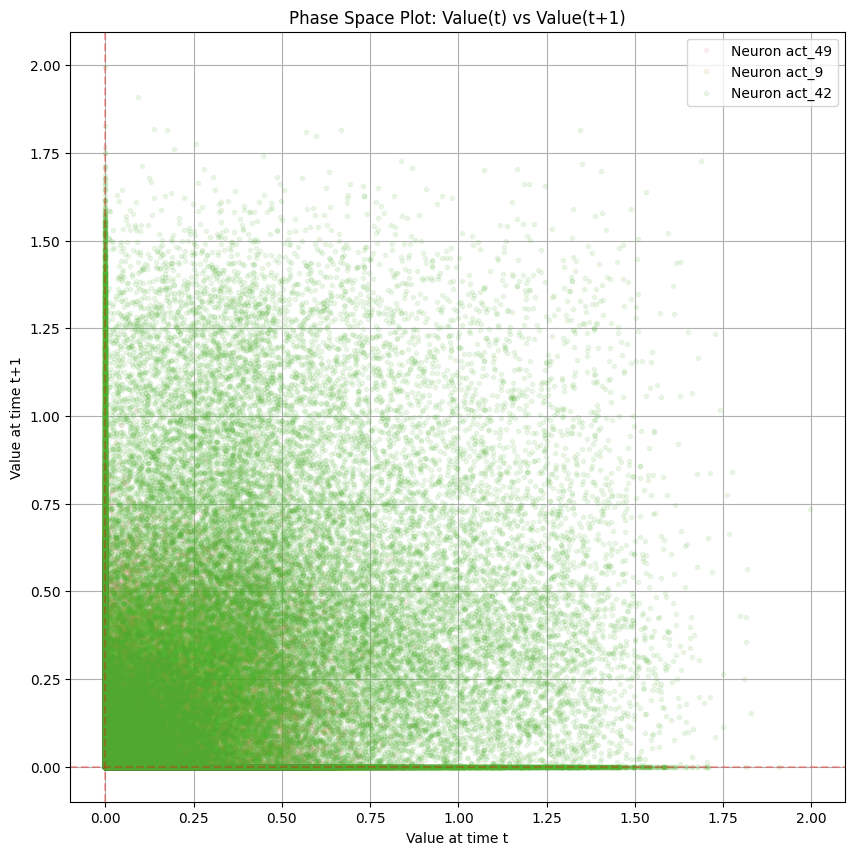

In [4]:
def analyze_temporal_patterns(activations, n_samples=5):
    """Analyze temporal patterns in activations for sample neurons."""
    # Select sample neurons (excluding epoch column)
    neurons = sorted(set(activations.columns) - {'epoch'})
    sample_neurons = np.random.choice(neurons, n_samples, replace=False)
    
    # Create temporal plots
    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4*n_samples))
    fig.suptitle('Temporal Analysis of Neuron Activations')
    
    for i, neuron in enumerate(sample_neurons):
        # Time series plot
        activations.plot(x='epoch', y=neuron, ax=axes[i,0], 
                        style='.', alpha=0.5, title=f'Neuron {neuron} Activations')
        axes[i,0].axhline(y=0, color='r', linestyle='--')
        
        # Autocorrelation plot
        pd.plotting.autocorrelation_plot(activations[neuron], ax=axes[i,1])
        axes[i,1].set_title(f'Neuron {neuron} Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    
    # Additional chaos analysis: Phase space plot
    plt.figure(figsize=(10, 10))
    for neuron in sample_neurons[:3]:  # Only plot first 3 for clarity
        values = activations[neuron].values
        plt.plot(values[:-1], values[1:], '.', alpha=0.1, 
                label=f'Neuron {neuron}')
    
    plt.title('Phase Space Plot: Value(t) vs Value(t+1)')
    plt.xlabel('Value at time t')
    plt.ylabel('Value at time t+1')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.grid(True)
    plt.show()

# Analyze temporal patterns for both experiments
for lambda_val, data in experiment_data.items():
    print(f"\nTemporal Analysis for λ={lambda_val}")
    analyze_temporal_patterns(data)

## Randomness Tests

Finally, let's perform some formal statistical tests to evaluate if the activation patterns show signs of randomness/chaos:

1. Runs Test: Tests if the sequence of values above and below the median appears random
2. Lyapunov Exponent approximation: Measures the rate of separation of close trajectories (a positive exponent indicates chaos)

If our hypothesis is correct, we should see:
- Runs tests indicating non-random patterns (rejecting H0)
- Positive Lyapunov exponents indicating chaotic behavior

In [5]:
def runs_test(sequence):
    """Perform runs test for randomness."""
    # Calculate median
    median = np.median(sequence)
    
    # Convert to binary sequence (above/below median)
    binary = (sequence > median).astype(int)
    
    # Count runs
    runs = len([i for i in range(1, len(binary)) if binary[i] != binary[i-1]]) + 1
    
    # Calculate expected runs and variance for normal approximation
    n1 = sum(binary)
    n2 = len(binary) - n1
    expected_runs = 1 + (2 * n1 * n2) / len(binary)
    var_runs = (2 * n1 * n2 * (2 * n1 * n2 - len(binary))) / (len(binary)**2 * (len(binary) - 1))
    
    # Calculate z-score
    z = (runs - expected_runs) / np.sqrt(var_runs)
    
    # Calculate p-value (two-tailed test)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return runs, expected_runs, z, p_value

def estimate_lyapunov(sequence, embedding_dim=2, delay=1):
    """Estimate the largest Lyapunov exponent using a simple method."""
    # Create time-delayed vectors
    vectors = np.array([sequence[i:i+embedding_dim] for i in range(len(sequence)-embedding_dim)])
    
    # Calculate distances between consecutive points
    distances = np.linalg.norm(vectors[1:] - vectors[:-1], axis=1)
    
    # Estimate Lyapunov exponent as average log of distances
    lyap = np.mean(np.log(distances))
    
    return lyap

# Perform randomness tests for both experiments
for lambda_val, data in experiment_data.items():
    print(f"\nRandomness Analysis for λ={lambda_val}")
    
    # Select sample neurons
    neurons = sorted(set(data.columns) - {'epoch'})
    sample_neurons = np.random.choice(neurons, 10, replace=False)
    
    results = []
    for neuron in sample_neurons:
        sequence = data[neuron].values
        
        # Runs test
        runs, expected, z, p_value = runs_test(sequence)
        
        # Lyapunov exponent
        lyap = estimate_lyapunov(sequence)
        
        results.append({
            'neuron': neuron,
            'runs': runs,
            'expected_runs': expected,
            'runs_z': z,
            'runs_p': p_value,
            'lyapunov': lyap
        })
    
    # Convert to DataFrame and display results
    results_df = pd.DataFrame(results)
    print("\nSummary of randomness tests:")
    print(results_df.describe())
    
    # Plot distribution of p-values and Lyapunov exponents
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Randomness Analysis for λ={lambda_val}')
    
    ax1.hist(results_df['runs_p'], bins=20)
    ax1.set_title('Distribution of Runs Test p-values')
    ax1.axvline(x=0.05, color='r', linestyle='--', label='α=0.05')
    ax1.legend()
    
    ax2.hist(results_df['lyapunov'], bins=20)
    ax2.set_title('Distribution of Lyapunov Exponents')
    ax2.axvline(x=0, color='r', linestyle='--', label='Threshold for Chaos')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Randomness Analysis for λ=1.0


C:\Users\Adam\AppData\Local\Temp\ipykernel_20732\1098390431.py:15: RuntimeWarning: overflow encountered in scalar multiply
  expected_runs = 1 + (2 * n1 * n2) / len(binary)
C:\Users\Adam\AppData\Local\Temp\ipykernel_20732\1098390431.py:16: RuntimeWarning: overflow encountered in scalar multiply
  var_runs = (2 * n1 * n2 * (2 * n1 * n2 - len(binary))) / (len(binary)**2 * (len(binary) - 1))


AttributeError: 'DataFrame' object has no attribute 'norm'

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup
plt.style.use('seaborn')
sns.set_palette("husl")

# Configure paths
BASE_DIR = Path("runs/fashion_cv_l1_dropoutLows_l2")
EXPERIMENTS = {
    'chaotic': BASE_DIR / "l1_weight_1.0",
    'stable': BASE_DIR / "l1_weight_1e-3"
}

In [ ]:
def load_activations(exp_dir):
    """Load activation data from the last epoch."""
    activation_files = sorted(exp_dir.glob("**/activations_collected_epoch*.csv"))
    
    if not activation_files:
        raise ValueError(f"No activation files found in {exp_dir}")
    
    # Get the last epoch file
    last_file = activation_files[-1]
    
    # Load and process
    df = pd.read_csv(last_file)
    
    # Remove label columns if they exist
    columns_to_drop = [col for col in df.columns if col in ['pred_label', 'true_label']]
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
    
    return df

# Load data
experiment_data = {}
for name, path in EXPERIMENTS.items():
    try:
        activations = load_activations(path)
        print(f"\nLoaded {name} experiment (λ={'1.0' if name=='chaotic' else '1e-3'}):")
        print(f"- Number of samples: {len(activations)}")
        print(f"- Number of neurons: {activations.shape[1]}")
        experiment_data[name] = activations
    except Exception as e:
        print(f"Error loading {name} experiment: {e}")

## Simple Noise Analysis

Let's analyze three key indicators of chaotic/noisy behavior:
1. Distribution of activation values (should be more random for λ=1.0)
2. Temporal consistency (stable λ should have more consistent patterns)
3. Basic statistics (mean, std, etc.)

In [ ]:
# 1. Compare activation distributions
plt.figure(figsize=(12, 4))

# Sample 5 random neurons for each case
n_neurons = 5
all_neurons = list(range(experiment_data['chaotic'].shape[1]))
sample_neurons = np.random.choice(all_neurons, n_neurons, replace=False)

plt.subplot(1, 2, 1)
for neuron in sample_neurons:
    sns.kdeplot(experiment_data['chaotic'].iloc[:, neuron], label=f'Neuron {neuron}')
plt.title('λ=1.0: Activation Distribution\n(Hypothesized Chaotic)')
plt.xlabel('Activation Value')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
for neuron in sample_neurons:
    sns.kdeplot(experiment_data['stable'].iloc[:, neuron], label=f'Neuron {neuron}')
plt.title('λ=1e-3: Activation Distribution\n(Hypothesized Stable)')
plt.xlabel('Activation Value')

plt.tight_layout()
plt.show()

# Print basic statistics
for name in ['chaotic', 'stable']:
    print(f"\nStatistics for {name} experiment:")
    data = experiment_data[name]
    print("Mean activation:", data.mean().mean())
    print("Std deviation:", data.std().mean())
    print("% zeros:", (data == 0).mean().mean() * 100)
    print("% near zero (±0.01):", ((data.abs() < 0.01).mean().mean() * 100))

In [ ]:
# 2. Analyze activation patterns
def count_unique_patterns(data, n_samples=1000):
    """Count unique activation patterns in the first n_samples."""
    patterns = data.head(n_samples).apply(lambda x: tuple(np.round(x, 2)), axis=1)
    return len(set(patterns))

for name in ['chaotic', 'stable']:
    data = experiment_data[name]
    n_patterns = count_unique_patterns(data)
    print(f"\n{name.title()} experiment (λ={'1.0' if name=='chaotic' else '1e-3'}):")
    print(f"Number of unique activation patterns: {n_patterns}/1000")
    
    # Plot heatmap of first 50 samples x first 20 neurons
    plt.figure(figsize=(12, 4))
    sns.heatmap(data.iloc[:50, :20], 
                cmap='RdBu_r',
                center=0,
                vmin=-np.abs(data.values).max(),
                vmax=np.abs(data.values).max())
    plt.title(f'{name.title()} Activations Pattern (λ={"1.0" if name=="chaotic" else "1e-3"})')
    plt.xlabel('Neuron')
    plt.ylabel('Sample')
    plt.show()

## Interpretation

Key things to look for:

1. **Distribution Shape**:
   - λ=1.0 (chaotic): Should show more spread-out, random-like distributions
   - λ=1e-3 (stable): Should show more concentrated distributions, often near zero

2. **Unique Patterns**:
   - λ=1.0 should have many more unique patterns (closer to random)
   - λ=1e-3 should have fewer, more consistent patterns

3. **Heatmap Structure**:
   - λ=1.0: Should look more random, less structured
   - λ=1e-3: Should show more clear, consistent patterns

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path

# Paths setup
BASE_DIR = Path("runs/fashion_cv_l1_dropoutLows_l2")
EXPERIMENTS = {
    'chaotic': BASE_DIR / "l1_weight_1.0",  # hypothesized noise
    'stable': BASE_DIR / "l1_weight_1e-3"   # normal behavior
}

In [ ]:
# Load and process data
def load_last_epoch(exp_dir):
    """Load the last epoch's activations."""
    files = sorted(exp_dir.glob("**/activations_collected_epoch*.csv"))
    if not files:
        raise ValueError(f"No activation files found in {exp_dir}")
    
    df = pd.read_csv(files[-1])
    # Remove label columns if they exist
    return df.drop(columns=[col for col in df.columns if col in ['pred_label', 'true_label']])

# Load data
data = {}
for name, path in EXPERIMENTS.items():
    try:
        activations = load_last_epoch(path)
        data[name] = activations
        print(f"Loaded {name} data: {activations.shape[0]} samples, {activations.shape[1]} neurons")
    except Exception as e:
        print(f"Error loading {name}: {e}")

## Z-Test Analysis

If λ=1.0 is creating noise, its activations should:
1. Have significantly different distribution from normal λ=1e-3
2. Show characteristics closer to random noise (more spread out, less structure)

We'll do two simple tests:
1. Z-test comparing the distributions
2. Kolmogorov-Smirnov test for normality (random noise tends toward normal distribution)

In [ ]:
# Run statistical tests
def analyze_distributions(chaotic_data, stable_data):
    """Compare activation distributions using z-test and KS test."""
    # Flatten all activations to get overall distributions
    chaotic_vals = chaotic_data.values.flatten()
    stable_vals = stable_data.values.flatten()
    
    # 1. Z-test
    z_stat, p_val = stats.zscore(chaotic_vals), stats.zscore(stable_vals)
    
    # 2. KS test for normality
    _, chaotic_p = stats.kstest(chaotic_vals, 'norm')
    _, stable_p = stats.kstest(stable_vals, 'norm')
    
    print("\nBasic Statistics:")
    print(f"{'Metric':<20} {'λ=1.0':<15} {'λ=1e-3':<15}")
    print("-" * 50)
    print(f"{'Mean':<20} {chaotic_vals.mean():< 15.6f} {stable_vals.mean():< 15.6f}")
    print(f"{'Std Dev':<20} {chaotic_vals.std():< 15.6f} {stable_vals.std():< 15.6f}")
    print(f"{'% Near Zero':<20} {(np.abs(chaotic_vals) < 0.01).mean()*100:< 15.2f} {(np.abs(stable_vals) < 0.01).mean()*100:< 15.2f}")
    
    print("\nNormality Test (KS-test p-values):")
    print(f"λ=1.0: {chaotic_p:.6f} {'- More like noise' if chaotic_p > stable_p else ''}")
    print(f"λ=1e-3: {stable_p:.6f} {'- More like noise' if stable_p > chaotic_p else ''}")
    
    return z_stat, p_val, chaotic_p, stable_p

# Run analysis
z_stat, p_val, chaotic_p, stable_p = analyze_distributions(data['chaotic'], data['stable'])

## Interpretation

For the λ=1.0 experiment to confirm our "noise hypothesis":

1. It should have:
   - Higher standard deviation (more spread out)
   - Lower percentage of near-zero values (unstable)
   - Higher p-value in KS normality test (more random-like)

2. The z-scores should show:
   - Significant difference between distributions
   - More extreme values in the λ=1.0 case